# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Objectives
The objective of the project is to determine which are the top offers to be sending each segment based on expected profits.

1. Which Offer?
2. Expected revenues & profits
3. Response prediction (TBD)

## Process:
**Which Offer?**
1. Explore & Pre-process data
2. Determine Demographic Splits
3. Perform A/B Testing Analysis for each offer per demographic (i.e. are differences statistically significant) wherever possible (use heuristics if sample size not big enough)
4. Determine which offers to send each demographic.

**Expected Profits**
Build regressional ML model to predict expected revenues for each segment's recommended offer

## 1. Data Exploration

In [79]:
import pandas as pd
import numpy as np
import math
import json
import itertools

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [80]:
print(portfolio.shape)
portfolio

(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [81]:
print(profile.shape)
profile.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [82]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [83]:
print(profile.gender.unique())
profile.groupby(['gender']).count()['income']

[None 'F' 'M' 'O']


gender
F    6129
M    8484
O     212
Name: income, dtype: int64

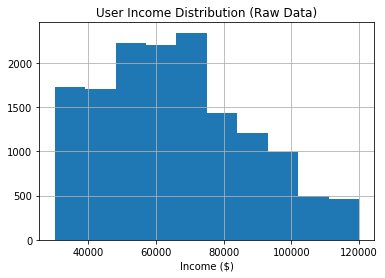

In [84]:
profile.income.hist()
plt.title("User Income Distribution (Raw Data)")
plt.xlabel("Income ($)")
plt.show()

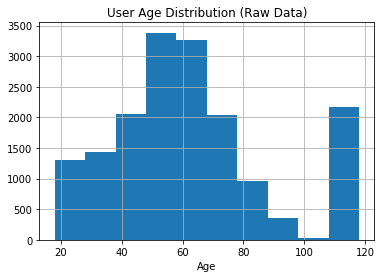

In [85]:
profile.age.hist()
plt.title("User Age Distribution (Raw Data)")
plt.xlabel("Age")
plt.show()

In [86]:
# Fill missing "income" values

# What % of values are missing?
print(round(profile.income.isna().sum() / profile.shape[0],2))

0.13


Does the age outlier group have anything to do with these NaN income values?

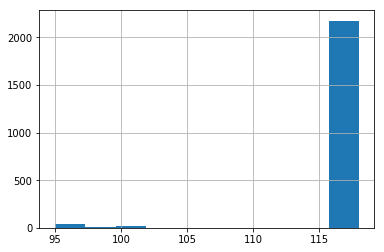

In [87]:
#Zoom into the 100+ age
profile[profile.age >= 95].age.hist()

In [88]:
#What's the maximum non-outlier age?
profile[(profile.age >= 100) & (profile.age < 118)].age.max()

101

In [89]:
#How many users with age "118"? Are they the source for the "NaN" incomes?
print(profile[profile.age == 118].shape[0])
print(profile.income.isna().sum())

2175
2175


**Users with Age 118 are the only ones without an "income" value. Given these users provide no segmentation value in either age or income, consider excluding from this analysis**

In [90]:
print(transcript.shape)
transcript.head(10)

(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [91]:
transcript[transcript.person == '54890f68699049c2a04d415abc25e717']

,event,person,time,value
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
36917,transaction,54890f68699049c2a04d415abc25e717,78,{'amount': 21.35}
59408,offer received,54890f68699049c2a04d415abc25e717,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
74810,offer viewed,54890f68699049c2a04d415abc25e717,186,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
109893,transaction,54890f68699049c2a04d415abc25e717,330,{'amount': 15.61}
109894,offer completed,54890f68699049c2a04d415abc25e717,330,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...
117069,offer received,54890f68699049c2a04d415abc25e717,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
145383,transaction,54890f68699049c2a04d415abc25e717,390,{'amount': 22.39}
145384,offer completed,54890f68699049c2a04d415abc25e717,390,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
156869,offer received,54890f68699049c2a04d415abc25e717,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [92]:
print(transcript.event.unique())
transcript['time'].describe()

['offer received' 'offer viewed' 'transaction' 'offer completed']


count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [93]:
transcript.groupby(['event']).count()['value']

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: value, dtype: int64

In [94]:
# How many transcript events use "None" gender?
uid_gender_none = np.array(profile[profile.gender.isnull()].id)

print("'None' Users:")
print(round(uid_gender_none.shape[0]/profile.shape[0],2))
print(uid_gender_none.shape[0])

print("'None' Events:")
print(round(transcript[transcript.person.isin(uid_gender_none)].shape[0]/transcript.shape[0],2))
print(transcript[transcript.person.isin(uid_gender_none)].shape[0])

'None' Users:
0.13
2175
'None' Events:
0.11
33772


## 2. Data Pre-processing 1

**table: portfolio**
- Dummy variables for "channels"

**table: profile**
- Convert "became member at" to date format
- Drop users with age "118"
- Create categorical variable for "age" group

**table: transcript**
- Feature extract "value" (i.e. "offer id", "amount")


**Segmentation**
1. Age
        -Millenials (19-38)
        -Gen X (39-54)
        -Baby Boomer (55-73)
        -Silent/Greatest Generation (74-100)
2. Gender
        -M
        -F
        -O
3. Income
        -30 ~ 49k
        -49 ~ 64k
        -64 ~ 80k
        -80 ~ 120k
4. Became Member On(?)

### 2.1 Pre-process Table: Portfolio

In [95]:
# Dummify "channels"
dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)

portfolio_proc = pd.concat([portfolio,dummies], axis=1)
portfolio_proc.drop(['channels'], axis=1, inplace=True)
portfolio_proc.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


### 2.2 Pre-process Table: Profile

In [96]:
# Convert "Became Member" to date
profile_proc = profile.copy()
profile_proc['became_member_on'] = pd.to_datetime(profile_proc['became_member_on'], format='%Y%m%d')
profile_proc.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [97]:
# As there are no missing "age" values, create column categorizing users by age groups
def categorize_age(x):
    if x <= 38:
        return 1
    elif 39 <= x <= 54:
        return 2
    elif 55 <= x <=73:
        return 3
    elif 74 <= x <= 101:
        return 4
    else:
        return np.nan
    
profile_proc['age_group'] = profile_proc['age'].apply(categorize_age)
profile_proc.dropna(subset=['age_group'], how='any', inplace=True)
profile_proc.head()

,age,became_member_on,gender,id,income,age_group
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,3.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,3.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,3.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3.0


In [98]:
def categorize_income(x):
    if x <= 49000:
        return 1
    elif 49000 < x <= 64000:
        return 2
    elif 64000 < x <=80000:
        return 3
    elif 80000 < x:
        return 4
    else:
        return np.nan
    
profile_proc['income_group'] = profile_proc['income'].apply(categorize_income)
profile_proc.head()

,age,became_member_on,gender,id,income,age_group,income_group
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,3.0,4
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4.0,4
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,3.0,3
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,3.0,2
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3.0,2


### 2.3 Pre-Process Table: Transcript

In [99]:
transcript_proc = transcript.copy()

# Create 'offer_id' column based on 'value' column
def generate_offer_col(x):
    if 'offer id' in x:
        return x['offer id']
    elif 'offer_id' in x:
        return x['offer_id']
    else:
        return 'transaction'

transcript_proc['offer_id'] = transcript_proc['value'].apply(generate_offer_col)

# Create 'amount' column based on 'value' column
def generate_amt_col(x):
    if 'amount' in x:
        return x['amount']
#     elif 'reward' in x:
#         return -x['reward']
    else:
        return 0

transcript_proc['amount'] = transcript_proc['value'].apply(generate_amt_col)
transcript_proc.drop(['value'], axis=1, inplace=True)
transcript_proc.head()

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0


In [100]:
transcript_proc[(transcript_proc.person == '2eeac8d8feae4a8cad5a6af0499a211d')]

,event,person,time,offer_id,amount
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0.00
53182,offer received,2eeac8d8feae4a8cad5a6af0499a211d,168,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00
65844,offer viewed,2eeac8d8feae4a8cad5a6af0499a211d,168,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00
85293,transaction,2eeac8d8feae4a8cad5a6af0499a211d,216,transaction,2.32
110835,offer received,2eeac8d8feae4a8cad5a6af0499a211d,336,fafdcd668e3743c1bb461111dcafc2a4,0.00
130152,offer viewed,2eeac8d8feae4a8cad5a6af0499a211d,348,fafdcd668e3743c1bb461111dcafc2a4,0.00
141567,transaction,2eeac8d8feae4a8cad5a6af0499a211d,378,transaction,5.29
187136,transaction,2eeac8d8feae4a8cad5a6af0499a211d,456,transaction,7.14
187137,offer completed,2eeac8d8feae4a8cad5a6af0499a211d,456,fafdcd668e3743c1bb461111dcafc2a4,0.00
243231,transaction,2eeac8d8feae4a8cad5a6af0499a211d,570,transaction,0.87


### 2.4 Determine Offer Usage for each user
As this step is a time-intensive pre-processing script (as it counts the number of offers users viewed & completed), I exported the results into a CSV. This allows us to avoid having to run this every time we perform tweaks to the analysis.

In [101]:
# Count # of true offer completions (i.e. excluding non-view completions)
# def count_completions(x, o_id):
#     user_offer_transcript = transcript_proc[(transcript_proc.person == x) & (transcript_proc.offer_id == o_id)]
    
#     num_viewed = user_offer_transcript[user_offer_transcript.event == 'offer viewed'].shape[0]
#     num_completed = user_offer_transcript[user_offer_transcript.event == 'offer completed'].shape[0]
    
#     if (o_id == "3f207df678b143eea3cee63160fa8bed") | (o_id == "5a8bc65990b245e5a138643cd4eb9837"):
#         return num_viewed
#     else:
#         true_completions = num_completed

#         if num_completed > num_viewed:
#             true_completions -= num_completed - num_viewed
        
#         return true_completions

# for o_id in portfolio.id:
#     profile_proc[o_id] = profile_proc.id.apply(count_completions, args=(o_id,))
    
#     print('Scanned offer {}'.format(o_id))
    
# profile_proc.head()

In [102]:
# profile_proc.to_csv('profile_proc.csv', index=False)

In [103]:
profile_proc = pd.read_csv('profile_proc.csv')
profile_proc.head()

,age,became_member_on,gender,id,income,age_group,income_group,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,3.0,4,0,0,0,0,0,0,0,0,0,0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4.0,4,1,0,0,1,0,0,0,1,1,0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,3.0,3,0,0,0,1,0,0,1,0,0,0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,3.0,2,0,0,0,1,0,0,1,0,2,1
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3.0,2,0,0,0,0,0,0,1,0,0,0


In [104]:
profile_proc.describe()

,age,income,age_group,income_group,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,2.456728,2.469815,0.218752,0.217605,0.235211,0.180034,0.106577,0.319325,0.328499,0.396155,0.269140,0.175987
std,17.383705,21598.299410,0.954952,1.113643,0.484625,0.480881,0.493264,0.432778,0.336405,0.562614,0.569875,0.609578,0.519852,0.430540
min,18.000000,30000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,66.000000,80000.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,101.000000,120000.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000


## 3. Determine Segments

Due to the relatively limited size of the dataset, we'll define our segments by (a) age, and (b) gender.

Though income would be another great variable for further segmentation, the 2 chosen variables capture more characteristics like consumer preferences and behavioral psychology.

1. Milennials, M
2. Milennials, F
3. Milennials, O
4. Gen X, M
5. Gen X, F
6. Gen X, O
7. Baby Boomer, M
8. Baby Boomer, F
9. Baby Boomer, O
10. Silent Gen, M
11. Silent Gen, F
12. Silent Gen, O

In [105]:
profile_proc.groupby('age_group')['id'].nunique()

age_group
1.0    2918
2.0    4220
3.0    5685
4.0    2002
Name: id, dtype: int64

In [106]:
# Part C - Create 'amount' column based on 'value' column
def generate_segments(row):
    groupNo = (row['age_group'] - 1) * 3 + 1
    
    if row['gender'] == 'M':
        return groupNo
    elif row['gender'] == 'F':
        return groupNo + 1
    else:
        return groupNo + 2

profile_proc['segment'] = profile_proc.apply(generate_segments, axis=1)
profile_proc.head()

,age,became_member_on,gender,id,income,age_group,income_group,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,segment
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,3.0,4,0,0,0,0,0,0,0,0,0,0,8.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,4.0,4,1,0,0,1,0,0,0,1,1,0,11.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,3.0,3,0,0,0,1,0,0,1,0,0,0,7.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,3.0,2,0,0,0,1,0,0,1,0,2,1,7.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,3.0,2,0,0,0,0,0,0,1,0,0,0,7.0


In [107]:
profile_proc.groupby('segment')['id'].nunique()

segment
1.0     2019
2.0      866
3.0       33
4.0     2501
5.0     1648
6.0       71
7.0     3038
8.0     2565
9.0       82
10.0     926
11.0    1050
12.0      26
Name: id, dtype: int64

In [108]:
profile_proc_temp = profile_proc[['id', 'segment']].copy()
profile_proc_temp.rename(columns = {'id':'person'}, inplace = True)

transcript_proc = pd.merge(transcript_proc, profile_proc_temp, on='person')
transcript_proc.head()

,event,person,time,offer_id,amount,segment
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,11.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,11.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,transaction,19.89,11.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,11.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,transaction,17.78,11.0


### 3.1 Segment Exploration (by Offer)

In [109]:
for o_id in portfolio.id:
    print("Offer: {}".format(o_id))
    print(round(
        profile_proc.groupby('segment')[o_id].sum() /
        transcript_proc[transcript_proc.event == 'offer received'].groupby(['offer_id', 'segment'])['time'].count()[o_id]*100))
    print("-----")

Offer: ae264e3637204a6fb9bb56bc8210ddfd
segment
1.0     29.0
2.0     57.0
3.0     35.0
4.0     42.0
5.0     60.0
6.0     79.0
7.0     44.0
8.0     60.0
9.0     56.0
10.0    50.0
11.0    59.0
12.0    70.0
dtype: float64
-----
Offer: 4d5c57ea9a6940dd891ad53e9dbe8da0
segment
1.0     24.0
2.0     55.0
3.0     43.0
4.0     43.0
5.0     65.0
6.0     68.0
7.0     44.0
8.0     62.0
9.0     69.0
10.0    48.0
11.0    63.0
12.0    50.0
dtype: float64
-----
Offer: 3f207df678b143eea3cee63160fa8bed
segment
1.0     35.0
2.0     41.0
3.0     36.0
4.0     57.0
5.0     64.0
6.0     79.0
7.0     52.0
8.0     55.0
9.0     82.0
10.0    57.0
11.0    54.0
12.0    58.0
dtype: float64
-----
Offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9
segment
1.0     26.0
2.0     37.0
3.0     50.0
4.0     40.0
5.0     51.0
6.0     69.0
7.0     37.0
8.0     44.0
9.0     53.0
10.0    38.0
11.0    46.0
12.0    71.0
dtype: float64
-----
Offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7
segment
1.0     11.0
2.0     17.0
3.0     16.0
4.0     25.0


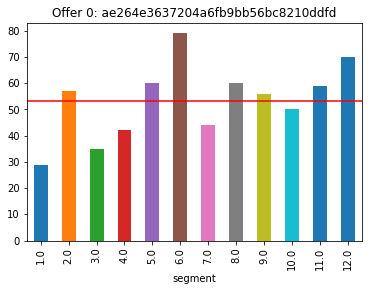

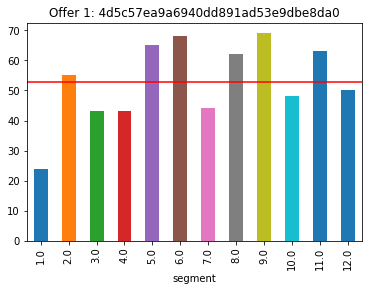

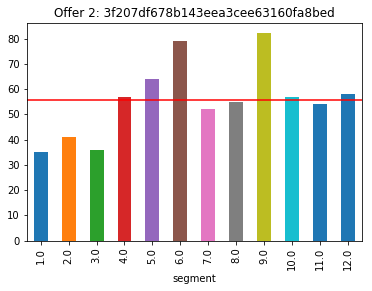

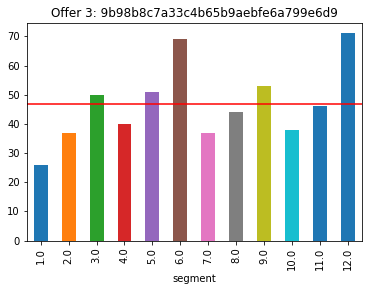

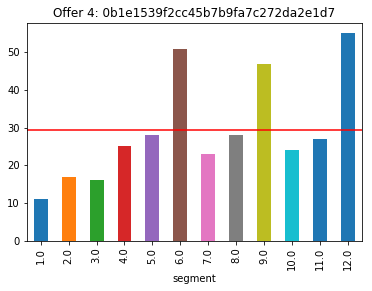

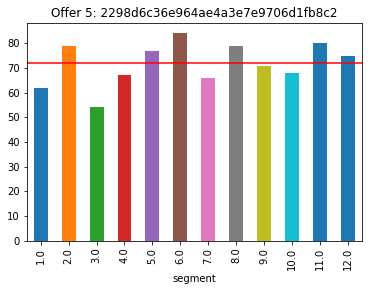

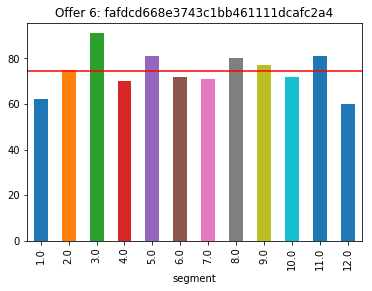

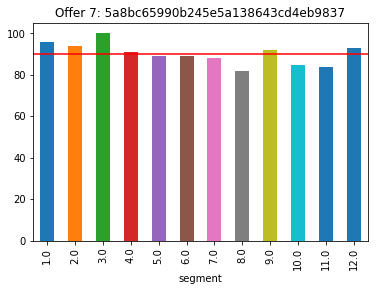

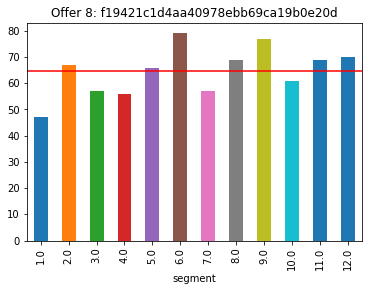

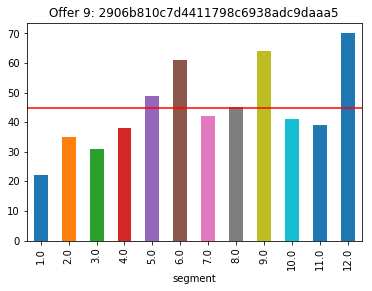

In [110]:
counter = 0
for o_id in portfolio.id:
    response_temp = round(
        profile_proc.groupby('segment')[o_id].sum() /
        transcript_proc[transcript_proc.event == 'offer received'].groupby(['offer_id', 'segment'])['time'].count()[o_id]*100)
    ax_resp = response_temp.plot.bar()
    ax_resp.set_title("Offer {}: {}".format(counter, o_id))
    
    ax_resp.axhline(response_temp.mean(), color='r')
    
    plt.show()
    
    counter += 1

### 3.2 Segment Exploration (by User Segment)

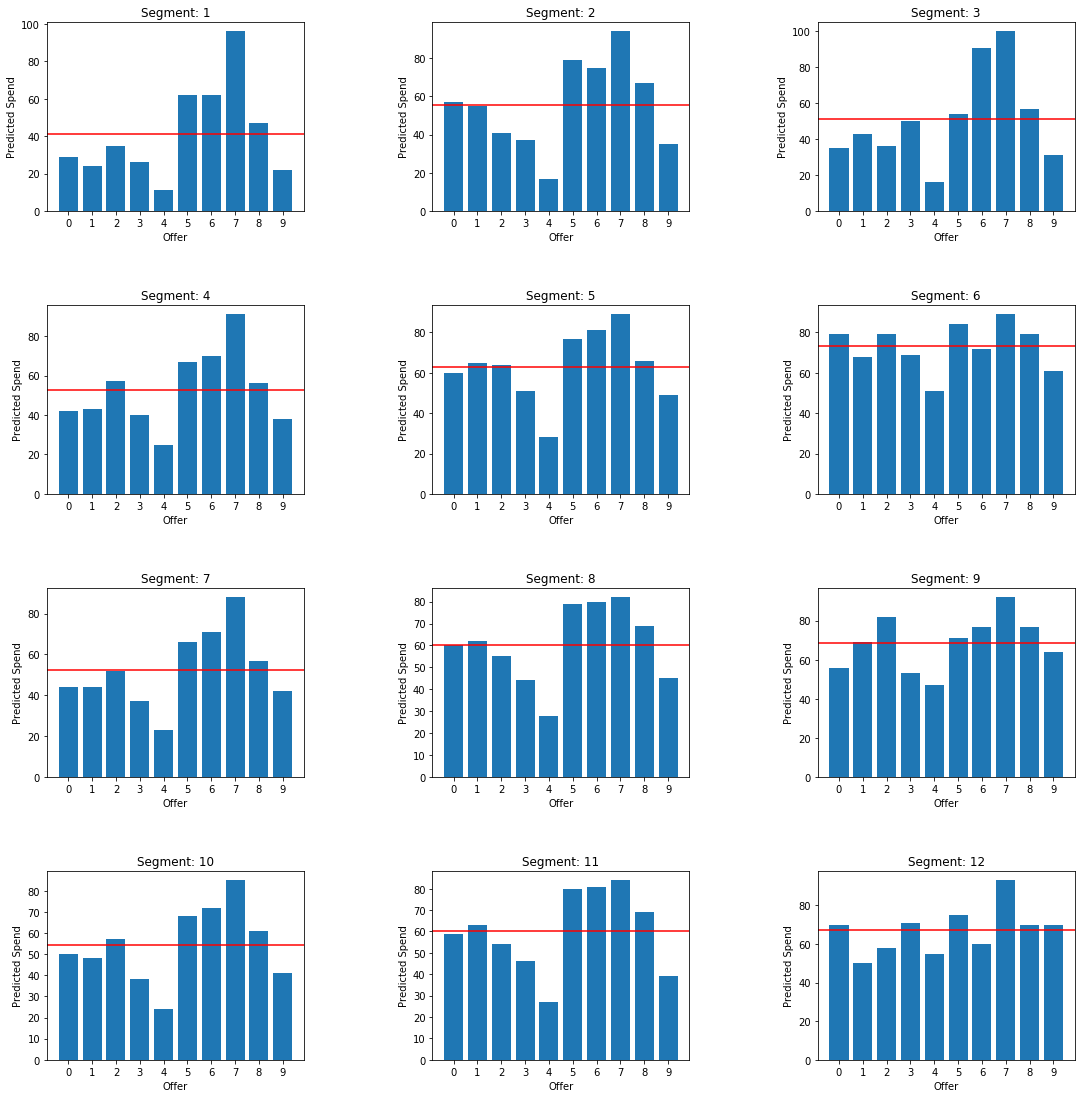

In [111]:
camp_codes = [
    'ae264e3637204a6fb9bb56bc8210ddfd',
    '4d5c57ea9a6940dd891ad53e9dbe8da0',
    '3f207df678b143eea3cee63160fa8bed',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7',
    '2298d6c36e964ae4a3e7e9706d1fb8c2',
    'fafdcd668e3743c1bb461111dcafc2a4',
    '5a8bc65990b245e5a138643cd4eb9837',
    'f19421c1d4aa40978ebb69ca19b0e20d',
    '2906b810c7d4411798c6938adc9daaa5'
]

# Plot top for each segment
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(hspace=.5, wspace=.5)

chart_x = 0
chart_y = -1

for seg_no in range(1,13):
    if ((seg_no-1) % 3 == 0) & (seg_no > 1):
        chart_x += 1
        chart_y = -1

    chart_y += 1
    
    response_temp = round(
        profile_proc.groupby('segment')[camp_codes].sum().loc[seg_no] /
        transcript_proc[transcript_proc.event == 'offer received'].groupby(['segment', 'offer_id'])['time'].count()[seg_no]*100)
    
    x = []
    for o_id in response_temp.index:
        x.append(portfolio_proc[portfolio_proc.id == o_id].index[0])
    
    y = response_temp.values
        
    axs[chart_x, chart_y].bar(x, y)
    axs[chart_x, chart_y].axhline(y.mean(), color='r')
    axs[chart_x, chart_y].set_title('Segment: {}'.format(seg_no))
    axs[chart_x, chart_y].set_ylabel("Predicted Spend")
    axs[chart_x, chart_y].set_xlabel("Offer")
    axs[chart_x, chart_y].set_xticks(x)

In [112]:
transcript_proc_temp = transcript_proc[(transcript_proc.event == 'offer received') & (transcript_proc.offer_id != 'transaction')]
transcript_proc_temp.groupby('offer_id')['time'].count()
# transcript_proc[(transcript_proc.offer_id == o_id) & (transcript_proc.event == 'offer received')].shape[0]

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7    6726
2298d6c36e964ae4a3e7e9706d1fb8c2    6655
2906b810c7d4411798c6938adc9daaa5    6631
3f207df678b143eea3cee63160fa8bed    6657
4d5c57ea9a6940dd891ad53e9dbe8da0    6593
5a8bc65990b245e5a138643cd4eb9837    6643
9b98b8c7a33c4b65b9aebfe6a799e6d9    6685
ae264e3637204a6fb9bb56bc8210ddfd    6683
f19421c1d4aa40978ebb69ca19b0e20d    6576
fafdcd668e3743c1bb461111dcafc2a4    6652
Name: time, dtype: int64

## Step 3 - Modeling
Now that we have a complete dataset, we will perform the modelling, by following these steps:
1. Split data (into training & test datasets)
2. Instantiate, train, test, score candidate models
3. Train chosen model
4. Generate predictions to answer questions (using predict, coefficients)

### 3.0 - Final Pre-processing & Exploration (for regression ML)
Before running the data through regressional models, there are a few pre-processing steps remaining (i.e. dummy variables for categoricals), and data exploration (to help choose candidate models, by observing factors like colinearity).

In [113]:
transcript_proc_temp = transcript_proc.copy()
transcript_proc_temp.rename(columns = {'person':'id'}, inplace = True)
transcript_proc_temp = transcript_proc_temp.groupby('id', as_index=False)['amount'].sum()

profile_ml = pd.merge(profile_proc, transcript_proc_temp, on='id')

profile_ml.drop(['became_member_on', 'age_group', 'income_group', 'segment'], axis=1, inplace=True)

profile_ml.head()

,age,gender,id,income,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,amount
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,0,0,0,0,0,0,77.01
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,1,0,0,0,1,1,0,159.27
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,1,0,0,1,0,0,0,57.73
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,1,0,0,1,0,2,1,36.43
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,0,0,1,0,0,0,15.62


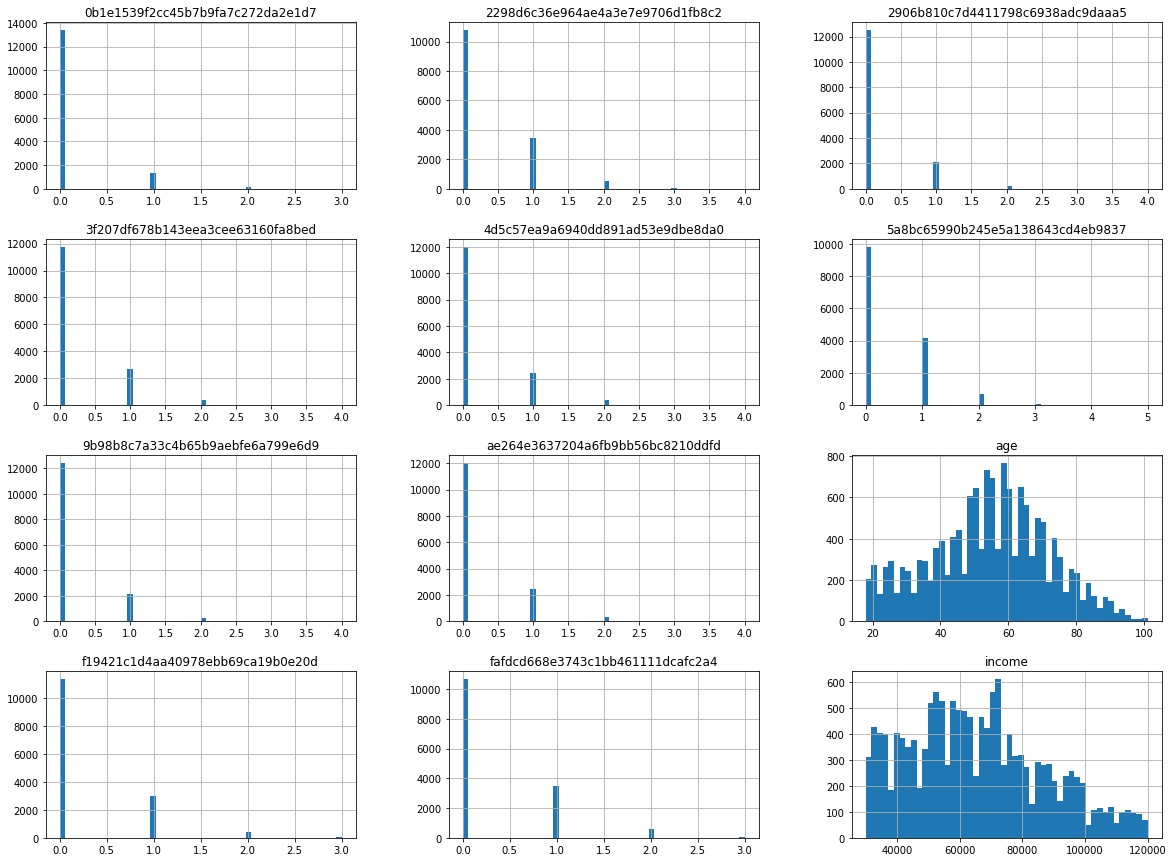

In [114]:
# Visualize quantitative variables (to observe distributions)
profile_quant = profile_ml[np.append(['age', 'income'], camp_codes)]

profile_quant.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

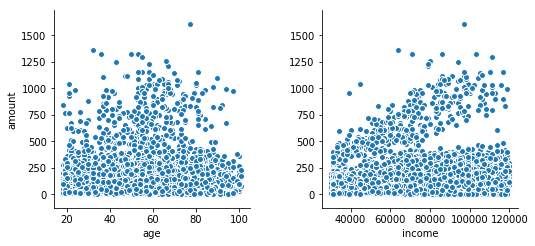

In [115]:
pp = sns.pairplot(data=profile_ml,
                  y_vars=['amount'],
                  x_vars=['age', 'income'])

pp.fig.set_figwidth(8)
pp.fig.set_figheight(4)

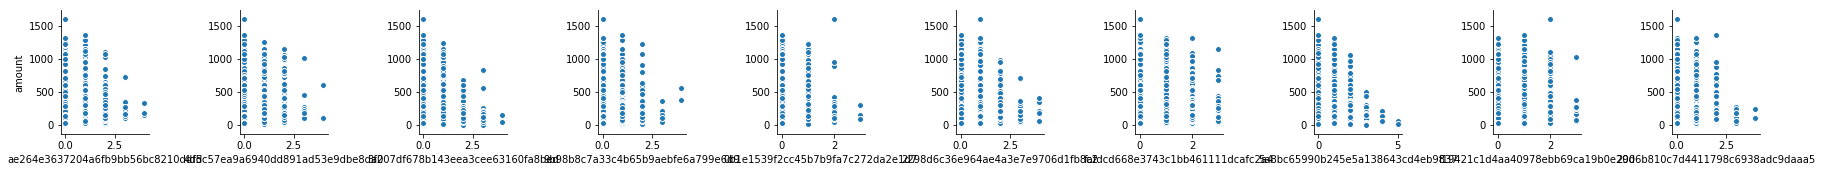

In [116]:
pp = sns.pairplot(data=profile_ml,
                  y_vars=['amount'],
                  x_vars=camp_codes)

**Observation: Most likely not a linear regressoin model (based on the relationship age & income have on total spending)**

In [117]:
# Drop user ID
profile_ml.drop(['id'], axis=1, inplace=True)

# Dummify categorical variables
profile_ml = pd.concat([profile_ml.drop('gender', axis=1), pd.get_dummies(profile_ml['gender'], prefix='gender')], axis=1)
profile_ml.head()

,age,income,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,amount,gender_F,gender_M,gender_O
0,55,112000.0,0,0,0,0,0,0,0,0,0,0,77.01,1,0,0
1,75,100000.0,1,0,0,1,0,0,0,1,1,0,159.27,1,0,0
2,68,70000.0,0,0,0,1,0,0,1,0,0,0,57.73,0,1,0
3,65,53000.0,0,0,0,1,0,0,1,0,2,1,36.43,0,1,0
4,58,51000.0,0,0,0,0,0,0,1,0,0,0,15.62,0,1,0


### 3.1 - Train-Test Split

In [118]:
X = profile_ml.drop(['amount'],axis=1)
y = profile_ml['amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 3.2 - Instantiate, Train, Test Models

**Option A - Linear Regression**

In [119]:
# Get Linear model up & running...

# Instantiate & train
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)

# Predict testing data
pred_train = lm_model.predict(X_train)
pred_test = lm_model.predict(X_test)

# Score
train_score = r2_score(y_train, pred_train)
test_score = r2_score(y_test, pred_test)

print(train_score)
print(test_score)

0.331703877784
0.288287169047


**Option B - Lasso Regression**

In [120]:
# Get Lasso model up & running...

# Instantiate & train
las_model = Lasso()
las_model.fit(X_train, y_train)

# Predict testing data
pred_train_las = las_model.predict(X_train)
pred_test_las = las_model.predict(X_test)

# Score
train_score_las = r2_score(y_train, pred_train_las)
test_score_las = r2_score(y_test, pred_test_las)

print(train_score_las)
print(test_score_las)

0.328667955028
0.286455724311


**Option C - Polynomial Model (degrees 2 - 4)**

In [121]:
# Get Polynomial model up & running...

for i in range(2,5):
    poly_feat = PolynomialFeatures(degree=i)
    X_poly_train = poly_feat.fit_transform(X_train)
    X_poly_test = poly_feat.fit_transform(X_test)

    poly_model = LinearRegression().fit(X_poly_train, y_train)

    # Predict testing data
    pred_train_poly = poly_model.predict(X_poly_train)
    pred_test_poly = poly_model.predict(X_poly_test)

    # Score
    train_score_poly = r2_score(y_train, pred_train_poly)
    test_score_poly = r2_score(y_test, pred_test_poly)

    print("{} degrees:".format(i))
    print(train_score_poly)
    print(test_score_poly)
    print(" ")

2 degrees:
0.353999886734
0.29097603916
 
3 degrees:
0.39300589153
0.242463940661
 
4 degrees:
0.360283883471
0.232378289492
 


**Conclusion: 2rd degree seems to have highest test R^2 scores.**

### 3.3 - Train & Predict using Chosen Model

In [122]:
# Proceed with analysis using 3rd degree polynomial
poly2_feat = PolynomialFeatures(degree=2)
X_poly2_train = poly2_feat.fit_transform(X_train)
X_poly2_test = poly2_feat.fit_transform(X_test)

poly2_model = LinearRegression().fit(X_poly2_train, y_train)

# Predict testing data
pred_train_poly2 = poly2_model.predict(X_poly2_train)
pred_test_poly2 = poly2_model.predict(X_poly2_test)

# Score
train_score_poly2 = r2_score(y_train, pred_train_poly2)
test_score_poly2 = r2_score(y_test, pred_test_poly2)

In [123]:
profile_ml.drop('amount', axis=1).columns

Index(['age', 'income', 'ae264e3637204a6fb9bb56bc8210ddfd',
       '4d5c57ea9a6940dd891ad53e9dbe8da0', '3f207df678b143eea3cee63160fa8bed',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9', '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4',
       '5a8bc65990b245e5a138643cd4eb9837', 'f19421c1d4aa40978ebb69ca19b0e20d',
       '2906b810c7d4411798c6938adc9daaa5', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [124]:
# For each of my identified segments, determine which offer(s) to send.
ages = [28, 45, 65, 80]
incomes = [40000, 56000, 72000, 100000]
colNames = np.array(profile_ml.drop('amount', axis=1).columns)

df_pred = pd.DataFrame(columns = np.append(colNames, ['amount_pred']))

segmentCount = 1
for age in ages:
    for g in range(0,3):
        for income in incomes:
            list_data_iters = []
            
            for offer_id in camp_codes:

                data_iter = {'age': age,
                'income': income,
                'ae264e3637204a6fb9bb56bc8210ddfd': 0,
                '4d5c57ea9a6940dd891ad53e9dbe8da0': 0,
                '3f207df678b143eea3cee63160fa8bed': 0,
                '9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
                '0b1e1539f2cc45b7b9fa7c272da2e1d7': 0,
                '2298d6c36e964ae4a3e7e9706d1fb8c2': 0,
                'fafdcd668e3743c1bb461111dcafc2a4': 0,
                '5a8bc65990b245e5a138643cd4eb9837': 0,
                'f19421c1d4aa40978ebb69ca19b0e20d': 0,
                '2906b810c7d4411798c6938adc9daaa5': 0,
                'gender_M': 0,
                'gender_F': 0,
                'gender_O': 0}

                data_iter[offer_id] = 1
                
                if g == 0:
                    data_iter['gender_M'] = 1
                elif g == 1:
                    data_iter['gender_F'] = 1
                else:
                    data_iter['gender_O'] = 1
                
                list_data_iters.append(data_iter)
#                 df_iter_new = pd.DataFrame(data_iter, columns = colNames)
#                 df_iter = df_iter.append(df_iter_new)
            
            df_iter = pd.DataFrame(list_data_iters, columns = colNames)
            
            df_iter_poly = poly2_feat.transform(df_iter)
            df_iter['amount_pred'] = poly2_model.predict(df_iter_poly)
            df_iter['segment'] = segmentCount
            
#             df_iter.sort_values(by=['segment','amount_pred'], ascending=False, inplace=True)
            df_pred = df_pred.append(df_iter)
            
        segmentCount += 1

df_pred.sort_values(by=['segment','amount_pred'], ascending=False, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

print(df_pred.shape)
df_pred.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(480, 17)


,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,age,amount_pred,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,gender_F,gender_M,gender_O,income,segment
0,1,0,0,0,0,0,0,0,80,131.179532,0,0,0,0,1,100000,12.0
1,1,0,0,0,0,0,0,0,80,123.046928,0,0,0,0,1,72000,12.0
2,1,0,0,0,0,0,0,0,80,119.897523,0,0,0,0,1,56000,12.0
3,0,0,0,0,0,0,1,0,80,119.350589,0,0,0,0,1,100000,12.0
4,1,0,0,0,0,0,0,0,80,117.837425,0,0,0,0,1,40000,12.0


### 3.4 - Analyze insights
#### Explore influence of income on offer effectiveness

In [127]:
def scatterplot_seg(s_no):
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,10))

    chart_x = 0
    chart_y = -1
    
    offerCount = 0
    for o_id in camp_codes:
        if ((offerCount) % 5 == 0) & (offerCount > 0):
            chart_x += 1
            chart_y = -1

        chart_y += 1

        x = df_pred[(df_pred.segment == s_no) & (df_pred[o_id] == 1)].income.astype(float)
        y = df_pred[(df_pred.segment == s_no) & (df_pred[o_id] == 1)].amount_pred
        
        axs[chart_x, chart_y].scatter(x, y)
        axs[chart_x, chart_y].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='r')
        axs[chart_x, chart_y].set_title('Offer: {}'.format(portfolio[portfolio.id == o_id].index[0]))
        
        offerCount += 1

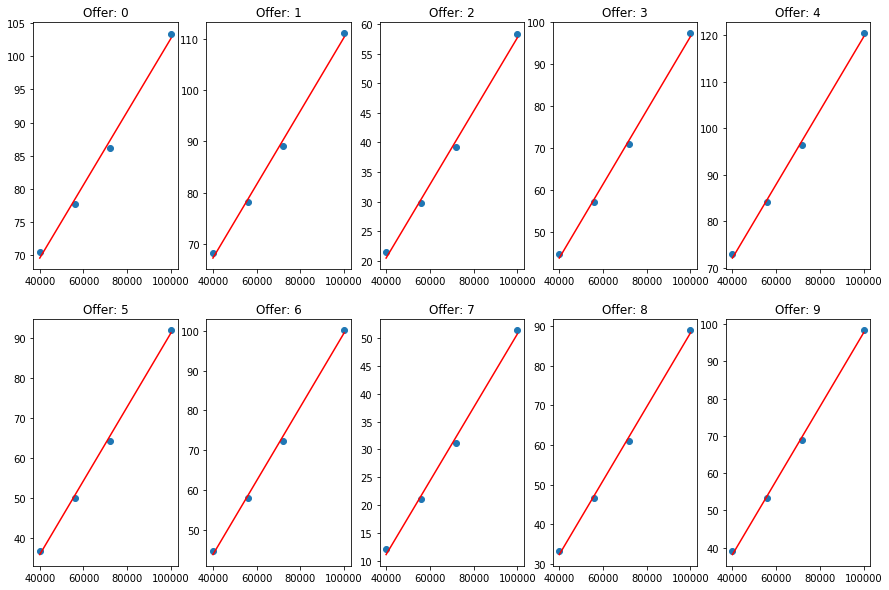

In [128]:
scatterplot_seg(7)

#### Explore top results

In [129]:
# Compile top results
summary_cols = ['segment', 'campaign', 'income', 'amount_pred']
df_pred_summary = pd.DataFrame(columns = summary_cols)

for i in range(1,13):
    seg_df = df_pred[(df_pred.segment == i)].head()
    
    offer_ids = []
    
    for row in seg_df.iterrows():
        for camp_id in camp_codes:
            if row[1][camp_id] == 1:
                offer_ids.append(camp_id)
                break
    
    solution_data = {
        'segment': [i, i, i, i, i],
        'campaign': offer_ids,
        'income': seg_df['income'].values,
        'amount_pred': seg_df['amount_pred'].values
    }
    
    df_iter = pd.DataFrame(solution_data, columns = summary_cols)
    df_pred_summary = df_pred_summary.append(df_iter)

portfolio_proc_temp = portfolio_proc[['difficulty', 'duration', 'id', 'offer_type', 'reward']]
portfolio_proc_temp.rename({'id': 'campaign'}, axis=1, inplace=True)
df_pred_summary = pd.merge(df_pred_summary, portfolio_proc_temp, on='campaign')

df_pred_summary.sort_values(by=['segment', 'amount_pred'], ascending=False, inplace=True)

df_pred_summary['amount_pred'] = round(df_pred_summary['amount_pred'])

print(df_pred_summary.shape)
df_pred_summary

(60, 8)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,segment,campaign,income,amount_pred,difficulty,duration,offer_type,reward
21,12,0b1e1539f2cc45b7b9fa7c272da2e1d7,100000,131.0,20,10,discount,5
22,12,0b1e1539f2cc45b7b9fa7c272da2e1d7,72000,123.0,20,10,discount,5
23,12,0b1e1539f2cc45b7b9fa7c272da2e1d7,56000,120.0,20,10,discount,5
58,12,9b98b8c7a33c4b65b9aebfe6a799e6d9,100000,119.0,5,7,bogo,5
24,12,0b1e1539f2cc45b7b9fa7c272da2e1d7,40000,118.0,20,10,discount,5
20,11,0b1e1539f2cc45b7b9fa7c272da2e1d7,100000,121.0,20,10,discount,5
54,11,fafdcd668e3743c1bb461111dcafc2a4,100000,115.0,10,10,discount,2
47,11,2906b810c7d4411798c6938adc9daaa5,100000,113.0,10,7,discount,2
57,11,9b98b8c7a33c4b65b9aebfe6a799e6d9,100000,109.0,5,7,bogo,5
59,11,2298d6c36e964ae4a3e7e9706d1fb8c2,100000,109.0,7,7,discount,3


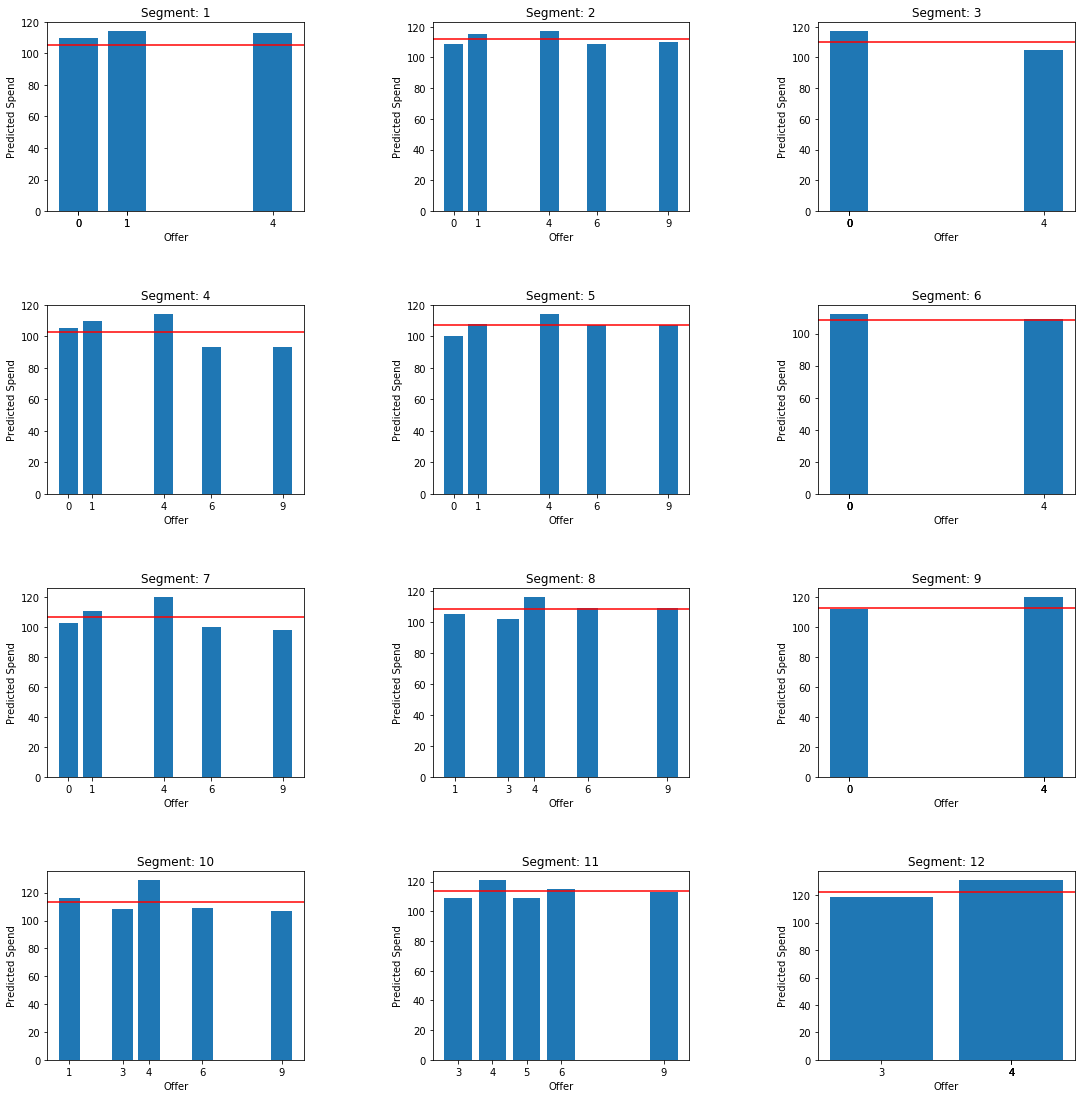

In [143]:
# Plot top for each segment
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
fig.tight_layout()
fig.subplots_adjust(hspace=.5, wspace=.5)

chart_x = 0
chart_y = -1

for i in range(1,13):
    if ((i-1) % 3 == 0) & (i > 1):
        chart_x += 1
        chart_y = -1

    chart_y += 1
    
    x = df_pred_summary[df_pred_summary.segment == i]['campaign_no']
    y = df_pred_summary[df_pred_summary.segment == i]['amount_pred']
    
#     ax_resp = df_pred_summary[df_pred_summary.segment == i].plot.bar(x='campaign_no', y='amount_pred')
#     ax_resp.set_title("Segment {}".format(i))
    
#     ax_resp.axhline(df_pred_summary[df_pred_summary.segment == i]['amount_pred'].mean(), color='r')
    
#     plt.show()
        
    axs[chart_x, chart_y].bar(x, y)
    axs[chart_x, chart_y].axhline(df_pred[df_pred.segment == i]['amount_pred'].nlargest().mean(), color='r')
    axs[chart_x, chart_y].set_title('Segment: {}'.format(i))
    axs[chart_x, chart_y].set_ylabel("Predicted Spend")
    axs[chart_x, chart_y].set_xlabel("Offer")
    axs[chart_x, chart_y].set_xticks(x)

#### Visualize top offers & expected spending

In [ ]:
# For plotting purposes, alias the offer ids with the index # from portfolio
df_pred_summary['campaign_no'] = df_pred_summary['campaign'].apply(lambda x: portfolio_proc[portfolio_proc.id == x].index[0])

In [135]:
# drop significantly lower results
# df_pred_summary_top = df_pred_summary.loc[[59, 52, 51, 43, 13, 12, 10, 8, 6, 25, 2, 0]]
df_pred_summary_top = df_pred_summary.loc[[21, 20, 19, 16, 15, 14, 34, 12, 11, 28, 9, 0]]
df_pred_summary_top = df_pred_summary_top[['segment', 'income', 'campaign', 'campaign_no', 'offer_type', 'difficulty', 'duration', 'reward', 'amount_pred']]
df_pred_summary_top.sort_values(by=['amount_pred'],ascending=False,inplace=True)
df_pred_summary_top

,segment,income,campaign,campaign_no,offer_type,difficulty,duration,reward,amount_pred
21,12,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,131.0
19,10,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,129.0
20,11,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,121.0
16,9,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,120.0
14,7,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,120.0
28,3,40000,ae264e3637204a6fb9bb56bc8210ddfd,0,bogo,10,7,10,117.0
9,2,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,117.0
15,8,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,116.0
12,5,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,114.0
11,4,100000,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,discount,20,10,5,114.0


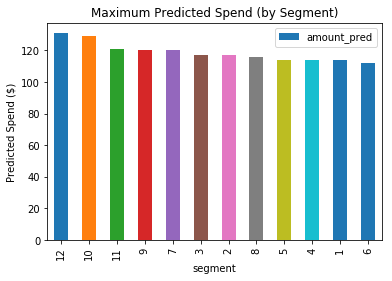

In [136]:
ax_resp = df_pred_summary_top.sort_values(by=['amount_pred'], ascending=False).plot.bar(x='segment', y='amount_pred')
ax_resp.set_title("Maximum Predicted Spend (by Segment)")
ax_resp.set_ylabel("Predicted Spend ($)")
plt.show()

#### Determine Breakdown of offer types in top 10s

In [134]:
offer_type_df = pd.DataFrame(df_pred_summary.groupby(['offer_type']).campaign_no.value_counts())
offer_type_df.rename({'campaign_no': 'frequency'}, axis=1, inplace=True)
offer_type_df

frequency
offer_type campaign_no           
bogo       0                   16
           1                    8
           3                    4
discount   4                   17
           6                    7
           9                    7
           5                    1

In [142]:
offer_type_df.groupby('offer_type').sum()

,frequency
offer_type,
bogo,28
discount,32
